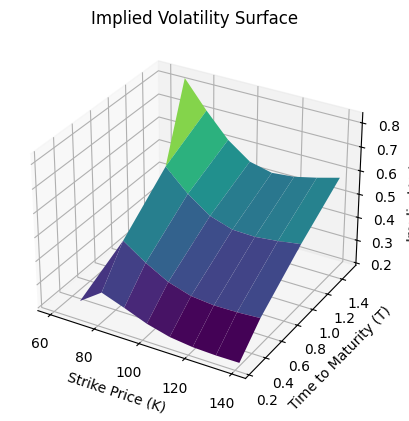

In [23]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt

# Given data
S = 100  # Current index price
r = 0.03  # Interest rate
strikes = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140])
maturities = np.array([0.25, 0.5, 1.0, 1.5])
call_prices = np.array([
    [40.2844, 42.4249, 50.8521, 59.1664],
    [30.5281, 33.5355, 42.6656, 51.2181],
    [21.0415, 24.9642, 34.4358, 42.9436],
    [12.2459, 16.9652, 26.4453, 34.7890],
    [5.2025, 10.1717, 19.4706, 27.8938],
    [1.3448, 5.4318, 14.4225, 23.3305],
    [0.2052, 2.7647, 11.2103, 20.7206],
    [0.0216, 1.4204, 9.1497, 19.1828],
    [0.0019, 0.7542, 7.7410, 18.1858]
])

# Black-Scholes Call Option Pricing Formula
def black_scholes_call(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return np.nan  # Return NaN for non-positive sigma or T

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Vega function: derivative of call price with respect to volatility
def vega(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return np.nan  # Return NaN for non-positive sigma or T

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

# Implied volatility using Newton-Raphson method
def implied_volatility_newton(C_market, S, K, T, r, tol=1e-6, max_iter=100):
    sigma = 0.2  # Initial guess for volatility
    epsilon = 1e-8  # Small epsilon to prevent division by zero

    for i in range(max_iter):
        price = black_scholes_call(S, K, T, r, sigma)
        vega_value = vega(S, K, T, r, sigma)
        
        # Check for valid vega_value to avoid division by zero
        if np.isnan(price) or np.isnan(vega_value) or vega_value < epsilon:
            return np.nan

        price_diff = price - C_market
        
        # Update step
        sigma_new = sigma - price_diff / vega_value
        
        # Check for convergence
        if abs(sigma_new - sigma) < tol:
            return sigma_new
        
        sigma = sigma_new

    # If convergence not reached, return NaN
    return np.nan

# Compute implied volatilities using Newton-Raphson
implied_vols = np.zeros(call_prices.shape)

for i, K in enumerate(strikes):
    for j, T in enumerate(maturities):
        implied_vols[i, j] = implied_volatility_newton(call_prices[i, j], S, K, T, r)

# Plotting the volatility surface without interpolation
K_grid, T_grid = np.meshgrid(strikes, maturities)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(K_grid, T_grid, implied_vols.T, cmap='viridis')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

plt.show()

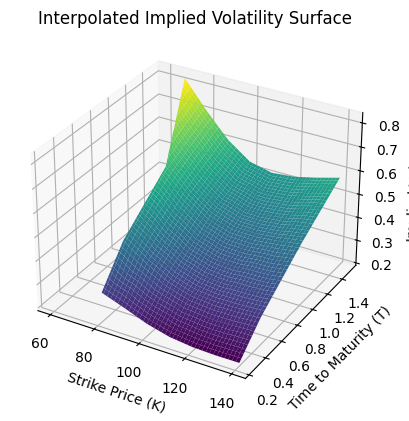

In [24]:
from scipy.interpolate import griddata

# Section B: Interpolation of the Implied Volatility Surface

# Define a finer grid for interpolation
K_fine = np.linspace(strikes.min(), strikes.max(), 1000)  # 1000 points between the min and max strikes
T_fine = np.linspace(maturities.min(), maturities.max(), 1000)  # 1000 points between the min and max maturities
K_grid_fine, T_grid_fine = np.meshgrid(K_fine, T_fine)

# Flatten the original grid points and the corresponding implied volatilities
K_flat = K_grid.flatten()
T_flat = T_grid.flatten()
implied_vols_flat = implied_vols.T.flatten()

# Perform bilinear interpolation using griddata
implied_vols_interpolated = griddata(
    (K_flat, T_flat),  # Original grid points
    implied_vols_flat,  # Corresponding implied volatilities
    (K_grid_fine, T_grid_fine),  # New grid points for interpolation
    method='linear'  # Bilinear interpolation
)

# Plot the interpolated volatility surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid_fine, T_grid_fine, implied_vols_interpolated, cmap='viridis')

ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Interpolated Implied Volatility Surface')

plt.show()


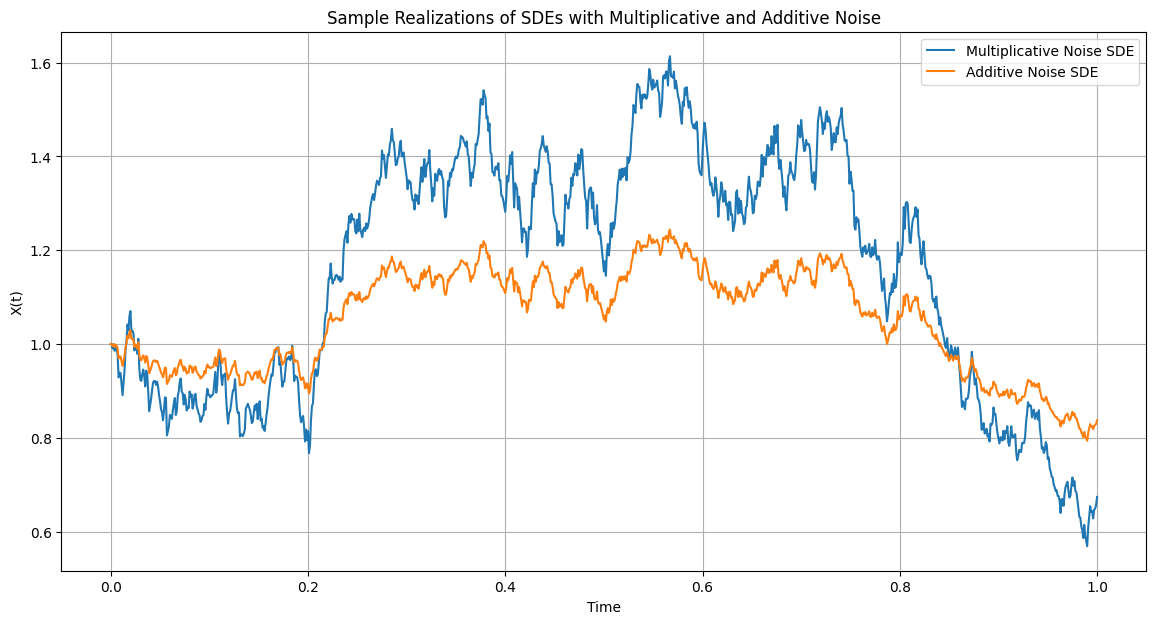

In [25]:
# Stochastic Differential Equations
# Parameters
T = 1.0  # Total time
N = 1000  # Number of time steps
dt = T / N  # Time step size
t = np.linspace(0, T, N+1)  # Time array

# Coefficients (example functions)
a1 = lambda t: 0.1
a2 = lambda t: 0.2
b1 = lambda t: 0.3
b2 = lambda t: 0.4

# Initial condition
X0 = 1.0

# Brownian motion
dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)

# Solution arrays
X_mult = np.zeros(N+1)
X_add = np.zeros(N+1)
X_mult[0] = X0
X_add[0] = X0

# Euler-Maruyama method for SDEs
for i in range(1, N+1):
    t_i = t[i-1]
    X_mult[i] = X_mult[i-1] + (a1(t_i) * X_mult[i-1] + a2(t_i)) * dt + (b1(t_i) * X_mult[i-1] + b2(t_i)) * dW[i-1]
    X_add[i] = X_add[i-1] + a1(t_i) * X_add[i-1] * dt + b1(t_i) * X_add[i-1] * dW[i-1]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(t, X_mult, label='Multiplicative Noise SDE')
plt.plot(t, X_add, label='Additive Noise SDE')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Sample Realizations of SDEs with Multiplicative and Additive Noise')
plt.legend()
plt.grid(True)
plt.show()


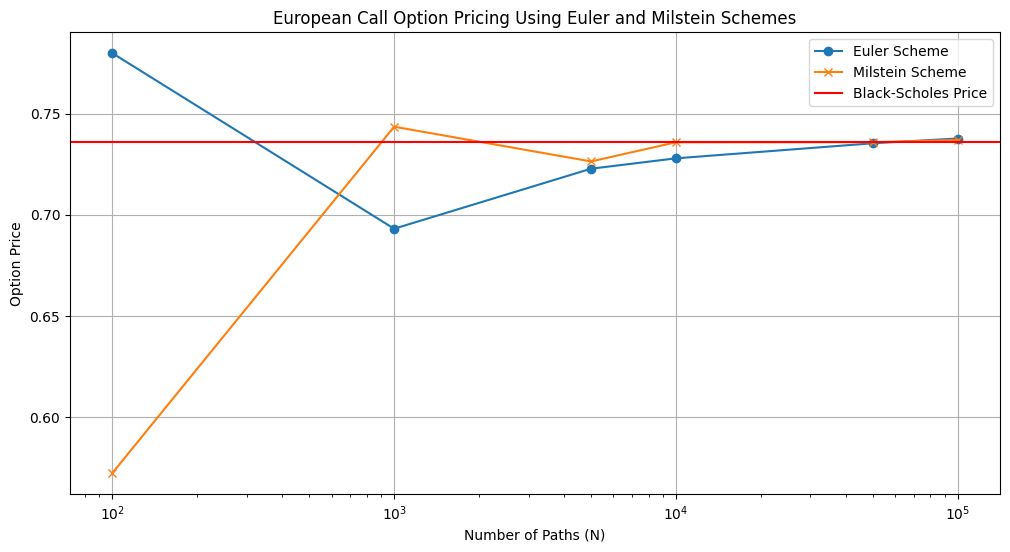

In [26]:
# Option Pricing Simulation Exercise

# Parameters
S0 = 5      # Initial stock price
K = S0      # Strike price (ATM option)
sigma = 0.3 # Volatility
r = 0.06    # Risk-free rate
T = 1.0     # Time to maturity
m = 1000    # Number of time steps
dt = T / m  # Time step size
N_values = [100, 1000, 5000, 10000, 50000, 100000]  # Number of paths

# Black-Scholes analytical price for European call option
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

bs_call_price = black_scholes_call(S0, K, T, r, sigma)

# Monte Carlo simulation using Euler scheme
def monte_carlo_euler(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z)

    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Monte Carlo simulation using Milstein scheme
def monte_carlo_milstein(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z + 0.5 * sigma**2 * dt * (Z**2 - 1))

    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Compute prices for different N values
euler_call_prices = []
milstein_call_prices = []

for N in N_values:
    euler_price = monte_carlo_euler(S0, K, T, r, sigma, N, m)
    milstein_price = monte_carlo_milstein(S0, K, T, r, sigma, N, m)
    euler_call_prices.append(euler_price)
    milstein_call_prices.append(milstein_price)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(N_values, euler_call_prices, label='Euler Scheme', marker='o')
plt.plot(N_values, milstein_call_prices, label='Milstein Scheme', marker='x')
plt.axhline(y=bs_call_price, color='r', linestyle='-', label='Black-Scholes Price')
plt.xlabel('Number of Paths (N)')
plt.ylabel('Option Price')
plt.title('European Call Option Pricing Using Euler and Milstein Schemes')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


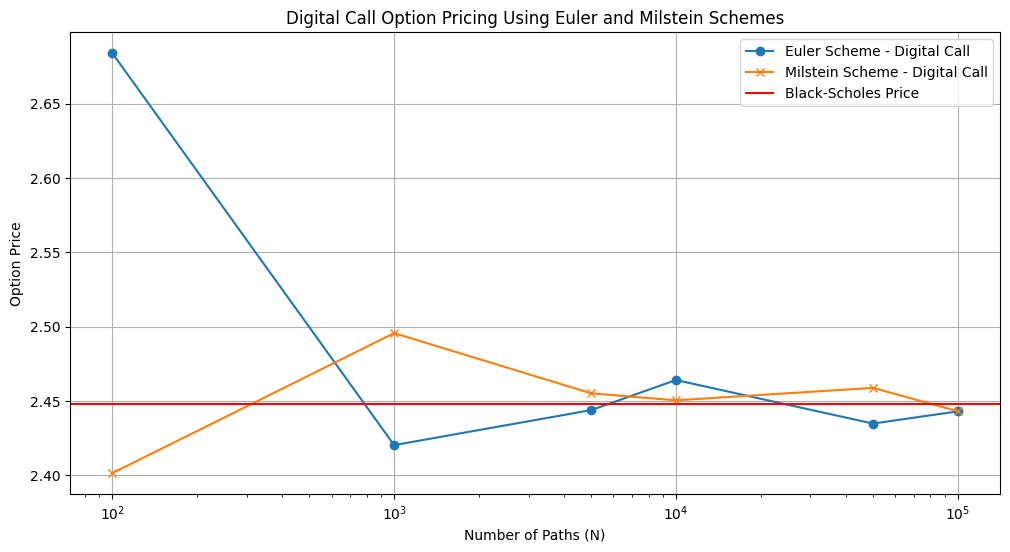

In [27]:
# Digital Call Option

# Parameters
S0 = 5      # Initial stock price
K = S0      # Strike price (ATM option)
sigma = 0.3 # Volatility
r = 0.06    # Risk-free rate
T = 1.0     # Time to maturity
m = 1000    # Number of time steps
dt = T / m  # Time step size
N_values = [100, 1000, 5000, 10000, 50000, 100000]  # Number of paths

# Black-Scholes analytical price for digital call option
def black_scholes_digital_call(S0, K, T, r, sigma):
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    digital_call_price = K * np.exp(-r * T) * norm.cdf(d2)
    return digital_call_price

bs_digital_price = black_scholes_digital_call(S0, K, T, r, sigma)

# Monte Carlo simulation using Euler scheme for digital call option
def monte_carlo_euler_digital(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z)

    # Payoff for digital call option
    payoffs = (S_paths[-1] > K).astype(float) * K
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Monte Carlo simulation using Milstein scheme for digital call option
def monte_carlo_milstein_digital(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z + 0.5 * sigma**2 * dt * (Z**2 - 1))

    # Payoff for digital call option
    payoffs = (S_paths[-1] > K).astype(float) * K
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Compute prices for different N values using both schemes
euler_digital_prices = []
milstein_digital_prices = []

for N in N_values:
    euler_price = monte_carlo_euler_digital(S0, K, T, r, sigma, N, m)
    milstein_price = monte_carlo_milstein_digital(S0, K, T, r, sigma, N, m)
    euler_digital_prices.append(euler_price)
    milstein_digital_prices.append(milstein_price)

# Plot results for digital call option
plt.figure(figsize=(12, 6))
plt.plot(N_values, euler_digital_prices, label='Euler Scheme - Digital Call', marker='o')
plt.plot(N_values, milstein_digital_prices, label='Milstein Scheme - Digital Call', marker='x')
plt.axhline(y=bs_digital_price, color='r', linestyle='-', label='Black-Scholes Price')
plt.xlabel('Number of Paths (N)')
plt.ylabel('Option Price')
plt.title('Digital Call Option Pricing Using Euler and Milstein Schemes')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()